# Optimize Portfolio Based on Forecast

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
from scipy.optimize import minimize

# Ensure directories exist
os.makedirs('../figs', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Historical Data and Prepare Forecasts

/home/bbm/Documents/projects/TimeSeries-Portfolio-Optimization/tsport_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


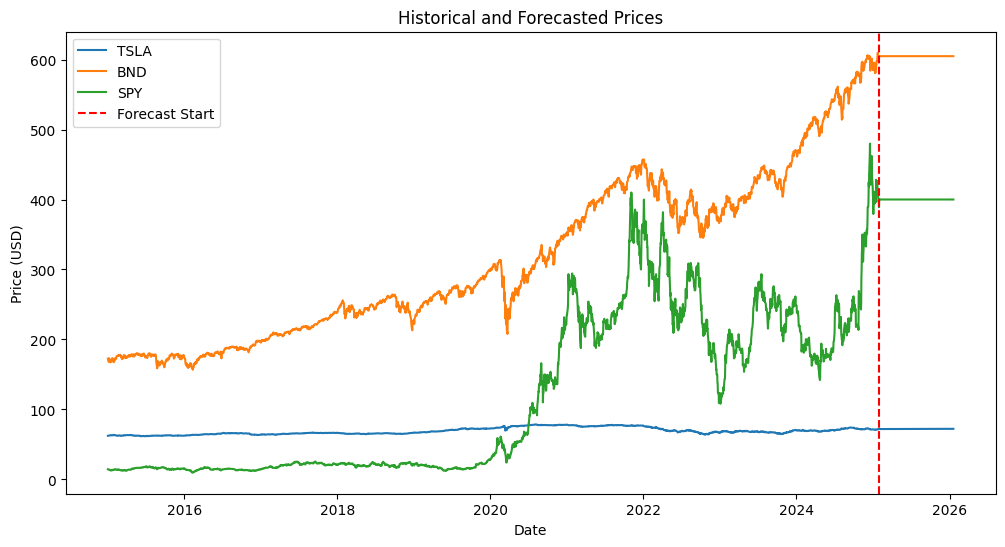

Last 5 rows of combined data:
                 TSLA         BND         SPY
2026-01-13  72.314472  604.835914  400.008811
2026-01-14  72.315844  604.835914  400.008811
2026-01-15  72.317217  604.835914  400.008811
2026-01-16  72.318590  604.835914  400.008811
2026-01-19  72.319964  604.835914  400.008811


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load historical adjusted close data from Task 1
adj_close = pd.read_csv('../data/raw/adj_close.csv', index_col='Date', parse_dates=True)

# Set frequency to business days ('B')
adj_close.index = pd.to_datetime(adj_close.index)
adj_close = adj_close.asfreq('B', method='ffill')

tickers = ['TSLA', 'BND', 'SPY']

# Forecast 12 months (252 trading days) for each asset
forecast_steps = 252
forecast_data = {}

for ticker in tickers:
    if ticker == 'TSLA':
        # Use ARIMA(1,1,1) with drift for TSLA to allow growth
        arima_fit = SARIMAX(adj_close[ticker].dropna(), order=(1, 1, 1), trend='t').fit(maxiter=50, disp=False)
    else:
        # Use ARIMA(1,1,1) for BND and SPY
        arima_fit = SARIMAX(adj_close[ticker].dropna(), order=(1, 1, 1)).fit(maxiter=50, disp=False)
    forecast = arima_fit.forecast(steps=forecast_steps)
    forecast_data[ticker] = forecast

# Generate future dates
last_date = adj_close.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='B')[1:]

# Combine forecasts into a DataFrame
forecast_df = pd.DataFrame(forecast_data, index=future_dates)

# Combine historical and forecasted data
df = pd.concat([adj_close[tickers], forecast_df], axis=0)

print("Combined historical and forecasted data:")
print(df.tail())

# Plot the forecasts
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(df.index, df[ticker], label=f'{ticker} (Historical + Forecast)')
plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
plt.title('Historical and Forecasted Prices (TSLA, BND, SPY)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('../figs/forecasted_prices.png')
plt.show()

## Compute Returns and Covariance

In [4]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Compute annualized returns (252 trading days)
annual_returns = ((1 + daily_returns.mean()) ** 252) - 1

# Compute covariance matrix (annualized)
cov_matrix = daily_returns.cov() * 252

print("Annualized Returns:")
print(annual_returns)
print("\nCovariance Matrix:")
print(cov_matrix)

Annualized Returns:
TSLA    0.013903
BND     0.131286
SPY     0.540739
dtype: float64

Covariance Matrix:
          TSLA       BND       SPY
TSLA  0.002603  0.000923  0.001573
BND   0.000923  0.027233  0.041330
SPY   0.001573  0.041330  0.287432


## Define Portfolio Metrics and Optimization Function

In [10]:
import numpy as np
from scipy.optimize import minimize

# Define portfolio return and volatility
def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.sum(weights * returns)
    port_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_return, port_volatility

# Define Sharpe Ratio (negative for minimization)
def neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.02):
    port_return, port_volatility = portfolio_performance(weights, returns, cov_matrix)
    return -(port_return - risk_free_rate) / port_volatility

# Constraints and bounds
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
    {'type': 'ineq', 'fun': lambda x: x[0] - 0.10}   # Minimum 10% for TSLA
]
bounds = tuple((0, 1) for _ in range(len(tickers)))  # Weights between 0 and 1

# Initial weights (equal allocation)
initial_weights = np.array([1/3, 1/3, 1/3])

# Optimize portfolio for maximum Sharpe Ratio
result = minimize(neg_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix, 0.02),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

print("Optimal Weights (TSLA, BND, SPY) with TSLA >= 10%:")
print(pd.Series(optimal_weights, index=tickers))

# Check portfolio performance
port_return, port_volatility = portfolio_performance(optimal_weights, annual_returns, cov_matrix)
sharpe_ratio = (port_return - 0.02) / port_volatility
print(f"Portfolio Return: {port_return:.4f}")
print(f"Portfolio Volatility: {port_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Optimal Weights (TSLA, BND, SPY) with TSLA >= 10%:
TSLA    0.100000
BND     0.461113
SPY     0.438887
dtype: float64
Portfolio Return: 0.2993
Portfolio Volatility: 0.2795
Sharpe Ratio: 0.9990


## Analyze Portfolio Risk and Return

In [11]:
# Calculate portfolio metrics with optimal weights
port_return, port_volatility = portfolio_performance(optimal_weights, annual_returns, cov_matrix)
sharpe_ratio = (port_return - 0.02) / port_volatility

# Calculate portfolio daily returns
portfolio_returns = (daily_returns * optimal_weights).sum(axis=1)

# Calculate Value at Risk (VaR) at 95% confidence for TSLA
tsla_returns = daily_returns['TSLA']
VaR_95_tsla = np.percentile(tsla_returns, 5) * df['TSLA'][-forecast_steps:].mean()  # Scaled to forecasted price

print(f"Portfolio Annual Return: {port_return:.4f}")
print(f"Portfolio Volatility (Std Dev): {port_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"TSLA VaR (95% Confidence, 1-day): ${-VaR_95_tsla:.2f}")

Portfolio Annual Return: 0.2993
Portfolio Volatility (Std Dev): 0.2795
Sharpe Ratio: 0.9990
TSLA VaR (95% Confidence, 1-day): $0.34


## Visualize Portfolio Performance

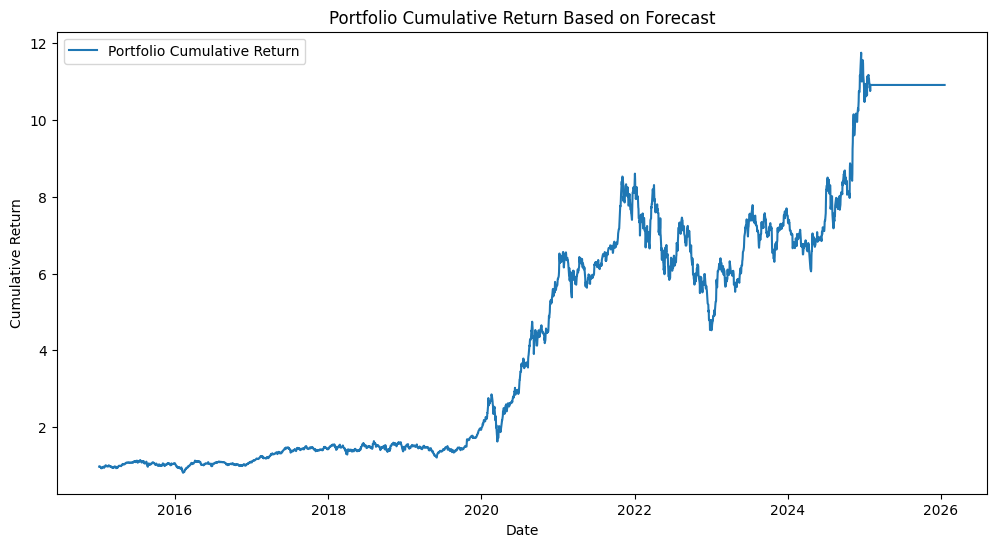

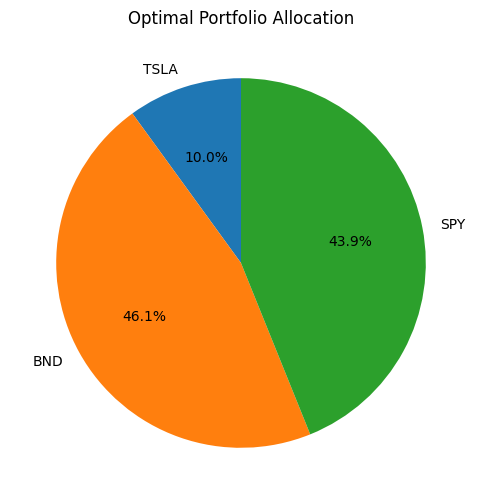

In [12]:
# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Portfolio Cumulative Return')
plt.title('Portfolio Cumulative Return Based on Forecast')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.savefig('../figs/portfolio_cumulative_return.png')
plt.show()

# Plot asset allocation
plt.figure(figsize=(8, 6))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Allocation')
plt.savefig('../figs/portfolio_allocation.png')
plt.show()